# One-Way ANOVA & Correlated Samples Designs



This lab / homework focuses on hypothesis tests in which you compare values from more than two means, as well as samples in which the data points are related. The tests you will work on in this lab are: One-Way Analysis of Variance (ANOVA) and Repeated Measures ANOVA. You will work with these concepts in this Notebook. 

## Assignment Goals

 - Develop familiarity with how to compare the means of multiple samples to detect the presence of differences, and how to examine multiple means when the data are not independent.
 - Understand the basic logic of how each test works, evaluate test assumptions, visualize relevant data, interpret results.

You will start by loading a dataset that will allow you to conduct a One-Way ANOVA. 


#  
  
## One Way ANOVA


Here, we will focus on one-way ANOVA, in which we compare data from more than two levels of a factor to test for the presence of differences amongst the means. The dataset we will use is from a study examining the effectiveness of three different diets (https://www.kaggle.com/datasets/alexandercox1234/3-diet-comparison). The file name is 'Diet_R.csv'. Participants were randomly assigned to treatments. The dataset contains the following variables:

- Person: the ID number of the participant
- gender: whether the participant identified as a woman (0) or man (1).
- Age: the participant's age in years
- Height: participant height in cm
- pre.weight: the participant's weight (kg) at the start of the study.
- Diet: a categorical variable that shows whether the participant had diet 1, 2, or 3
- weight6weeks: the participant's weight (kg) six weeks after starting the diet.


Obviously, the pre-diet and post-diet weight scores are related to one another (and therefore violate the assumption of independence required for this type of ANOVA) so we will not compare them directly. Instead, we will focus on a couple simple group comparisons for this part of the lab.

##### In lab this week, we will ask whether there are any group differences at the start of treatment (pre.weight). 

To help promote understanding, please follow the standard multi-step hypothesis testing process. The process we will follow is:

 - Specify your hypotheses
 - Specify the probability of making a Type I Error that you are willing to accept
 - Determine the test statistic you will compute and any exclusions you will use to remove data.
 - Summarize/visualize the relevant data
 - Plot the data and test assumptions
 - Conduct your hypothesis test
 - Interpret your result and describe it with reference to what your hypothesis means


In [1]:
# import statements
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

If participants were randomly assigned to groups, there should be no differences between the groups before the diet. Here, we are hoping that the evidence is consistent with the null hypothesis (if we reject H0, that will mean we have an error in our random assignment to groups).

- **H0:** There will be no differences between the diet groups at the start of the study.
- **H1:** There will be differences between the diet groups at the start of the study.
- **p-value:** .05
- **Test-statistic:** Because there are 3 treatment groups, we will use ANOVA to conduct an omnibus test
- **Exclusions** We will exclude outliers with scores +/- 3SDs from the mean.

In [2]:
# load the data
df = pd.read_csv('Diet_R.csv')
print(df.head(),'\n')
print(f'There are {len(df)} participants in the dataset.')

   Person  gender  Age  Height  pre.weight  Diet  weight6weeks
0       1       0   22     159          58     1          54.2
1       2       0   46     192          60     1          54.0
2       3       0   55     170          64     1          63.3
3       4       0   33     171          64     1          61.1
4       5       0   50     170          65     1          62.2 

There are 90 participants in the dataset.


The grand mean of participants pre-diet weights is: 72.1910 kg, sd = 8.0395.
The cut-off for low outliers is: 48.07251228124405
The cut-off for high outliers is: 96.30951019066606
The maximum starting weight in the dataset is: 88 kg.
The minimum starting weight in the dataset is: 58 kg.

Mean: Diet
1    72.866667
2    70.000000
3    73.633333
Name: pre.weight, dtype: float64

Standard Deviation: Diet
1    8.427105
2    8.008924
3    7.467093
Name: pre.weight, dtype: float64


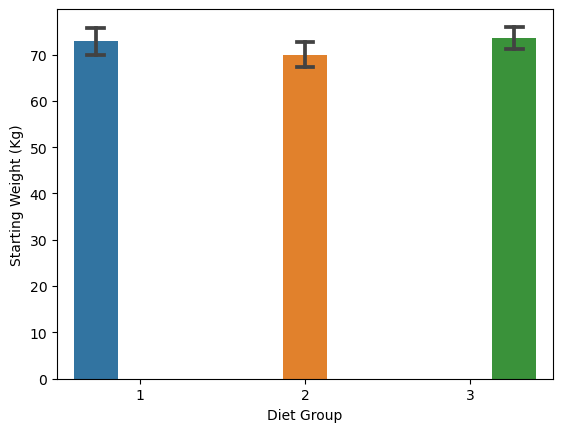

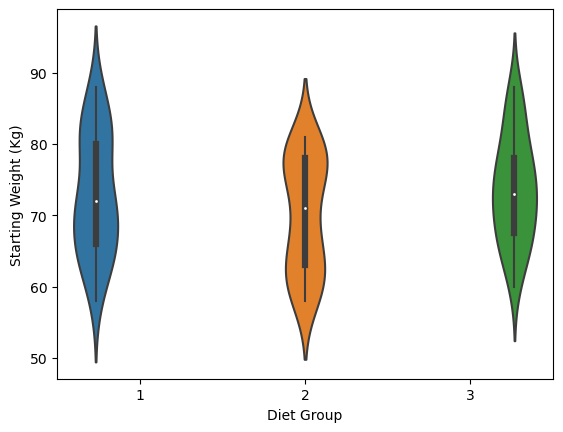

In [5]:
# Produce the overall descriptive statistics (including your outlier boundaries).
# Print the descriptive statistics for each group, a bar plot of the data by diet group, 
# and a violin plot of the same.

# Overall descriptive statistics
pre_grand_mean = np.mean(df['pre.weight'])
pre_grand_sd = np.std(df['pre.weight'], ddof=1)
print(f"The grand mean of participants pre-diet weights is: {pre_grand_mean:.4f} kg, sd = {pre_grand_sd:.4f}.")
print(f"The cut-off for low outliers is: {pre_grand_mean - (3 * pre_grand_sd)}")
print(f"The cut-off for high outliers is: {pre_grand_mean + (3 * pre_grand_sd)}")
print(f"The maximum starting weight in the dataset is: {max(df['pre.weight'])} kg.")
print(f"The minimum starting weight in the dataset is: {min(df['pre.weight'])} kg.\n")

# Group-level descriptive statistics
print(f"Mean: {df['pre.weight'].groupby(df['Diet']).mean()}")
print(f"\nStandard Deviation: {df['pre.weight'].groupby(df['Diet']).std(ddof=1)}")

# Plots
sns.barplot(data=df, x='Diet', y='pre.weight', hue='Diet', estimator=np.mean, errorbar=('ci', 95), palette='tab10', capsize=0.1)
plt.legend().remove()
plt.ylabel('Starting Weight (Kg)')
plt.xlabel('Diet Group')
plt.show()

sns.violinplot(data=df, x='Diet', y='pre.weight', hue='Diet', palette='tab10', legend=False)
plt.legend().remove()
plt.ylabel('Starting Weight (Kg)')
plt.xlabel('Diet Group')
plt.show()

In [4]:
# Remove the outlier from the data, saving it to the same dataframe variable where you loaded it originally. 
# Then re-run the code-cell above to re-compute the descriptive statistics.

df = df[df['pre.weight'] < 100]

#### To start with, we should make some basic observations from the plots.

- **Bar plot:** The means and 95%CIs look very similar across the groups. The variances of the data within groups are not perfectly, but reasonably similar. 
- **Violin plot:** The data look reasonably normally distributed in groups 1 and 3. However, group 2 does not look like it has a normal distribution (thie distribution looks bimodal instead). 



#### Next, we will formally check our assumptions. We will start with the Shapiro-Wilk test to check that the data are normally distributed. After that, we will run Levene's test to check our homogeneity of variance assumption.

In [6]:
# Check the normality of the data in each group. Do this with a loop.

for i in range(3):
    shapiro, p = stats.shapiro(df['pre.weight'].loc[df['Diet']==i + 1])
    if p < .05:
        print(f'The Diet {i + 1} weighs are NOT normally distributed at the study start.')
    else:
        print(f'The Diet {i + 1} weights are normally distributed at the study start.')

The Diet 1 weights are normally distributed at the study start.
The Diet 2 weighs are NOT normally distributed at the study start.
The Diet 3 weights are normally distributed at the study start.


In [7]:
# Levene's test here.

levine, pval = stats.levene(df['pre.weight'][df['Diet'] == 1],
                           df['pre.weight'][df['Diet'] == 2],
                           df['pre.weight'][df['Diet'] == 3])

if pval < .05:
    print('The pre-diet weights violate the assumption of homogeneity of variance.')
else:
    print('The pre-diet weights do not violate the assumption of homogeneity of variance.')

The pre-diet weights do not violate the assumption of homogeneity of variance.


Do your formal tests of the assumptions agree with your initial impressions from the violin plots? Why or why not?

Answer: The assumption of homogeneity of variance holds but normality is violated for group 2, the distribution there also looks non-normal.

#### Next, we will compute the ANOVA, using two methods. Based on our bar plot from above, we anticipate that we will fail to reject H0 (this is our desired outcome). Our first ANOVA will use the traditional theoretical/analytical method. Then, we will conduct a randomization test to make sure the results agree.

In [8]:
# Calculate the one-way ANOVA using scipy

anova_result, anova_pval = stats.f_oneway(df['pre.weight'][df['Diet'] == 1], df['pre.weight'][df['Diet'] == 2], df['pre.weight'][df['Diet'] == 3])

print(f'ANOVA statistic: {anova_result:.4f}, p = {anova_pval:.4f}')

ANOVA statistic: 1.6919, p = 0.1902


The mean of the sampling distribution of F is: 1.0349.
The standard deviation of the sampling distribution of F is: 1.0742.


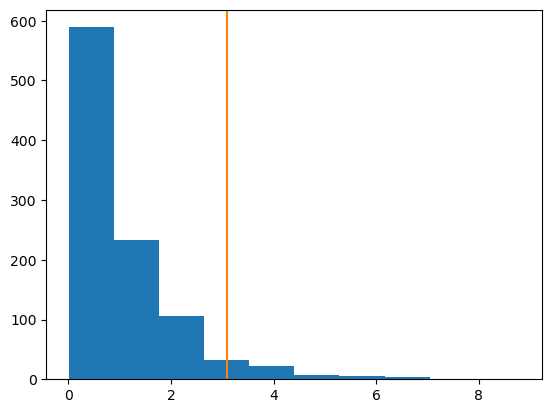

In [9]:
# Conduct your randomization test on pre.weight

# Here is a function that will do this.
def my_f_distribution(data, num_iterations, y_var):
    f_distn = np.empty(num_iterations)
    for i in range(num_iterations):
        data['Diet'] = data['Diet'].sample(frac=1).values
        fstat, pval = stats.f_oneway(data[y_var][data['Diet'] == 1], 
                                     data[y_var][data['Diet'] == 2], 
                                     data[y_var][data['Diet'] == 3])
        f_distn[i] = fstat # save f-value to distribution
    return f_distn

# Call the function

anova_distn = my_f_distribution(df.copy(), 1000, 'pre.weight')

# Plot the results

print(f"The mean of the sampling distribution of F is: {np.mean(anova_distn):.4f}.")
print(f"The standard deviation of the sampling distribution of F is: {np.std(anova_distn):.4f}.")

plt.hist(anova_distn)
plt.axvline(np.percentile(anova_distn, 95), color='tab:orange')
plt.show()

#### Finally, we will interpret the results (in an APA formatted statement).

Note: When one is reporting an ANOVA result, it is customary to state the type of ANOVA you have run, the F statistic, and the p-value reported to 3 decimal places. If the p-value is less than .001, it can be reported as 'p < .001'. In parentheses directly after the notation 'F' and before the calculated value of F, you should report the degrees of freedom numerator, followed by degrees of freedom denominator. 

A one-way analysis of variance, F(2, 86) = 1.69; p = .190, showed that there were no weight differences across the groups at the start of the study, meaning that the null hypothesis of no differences between the groups was not rejected (i.e., there were no differences between the groups). This result is consistent with the study design in which participants were randomized to treatment groups at the time of the study start. 

## <font color="blue"> *Homework Problem 1*</font>

Following the same steps as above and the code you wrote above as a model, test the following research question:

#### Are there any group differences at the end of treatment ('weight6weeks')?

Be sure to follow all the hypothesis testing steps (you will lose points on this problem if you do not). If you find outliers, please exclude them.

Be careful of copy and paste errors. If you copy and paste, be sure that you change your variables accordingly. 

YOUR RESPONSE HERE:

- **H0:** There are no group differences at the end of treatment.
- **H1:** There are group differences at the end of treatment. 
- **p-value:** The p-value I will use is 0.05.
- **Test-statistic:** The test-statistic is ANOVA because there are three treatment groups.
- **Exclusions** I will exclude any values +/- 3 SDs from the mean.

The grand mean of participants end of treatment weights is: 68.3303 kg, sd = 8.0460.
The cut-off for low outliers is: 44.19239240994764
The cut-off for high outliers is: 92.46828174735572
The maximum ending weight in the dataset is: 84.5 kg.
The minimum ending weight in the dataset is: 53.0 kg.

Mean: Diet
1    69.576667
2    66.882759
3    68.483333
Name: weight6weeks, dtype: float64

Standard Deviation: Diet
1    8.382851
2    7.683938
3    8.089503
Name: weight6weeks, dtype: float64


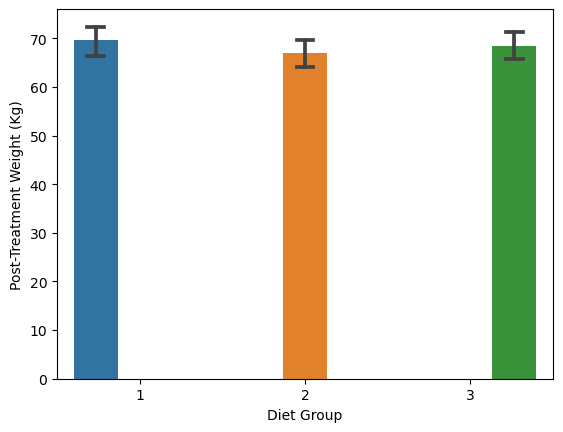

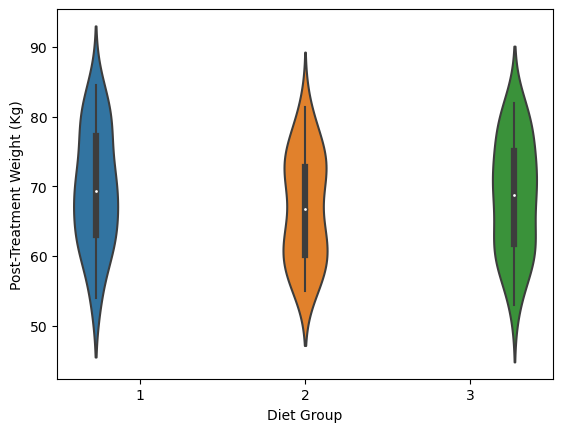

In [12]:
# Produce the overall descriptive statistics (including your outlier boundaries).
# Print the descriptive statistics for each group, a bar plot of the data by diet group, 
# and a violin plot of the same.

# Overall descriptive statistics

post_grand_mean = np.mean(df['weight6weeks'])
post_grand_sd = np.std(df['weight6weeks'], ddof=1)
print(f"The grand mean of participants end of treatment weights is: {post_grand_mean:.4f} kg, sd = {post_grand_sd:.4f}.")
print(f"The cut-off for low outliers is: {post_grand_mean - (3 * post_grand_sd)}")
print(f"The cut-off for high outliers is: {post_grand_mean + (3 * post_grand_sd)}")
print(f"The maximum ending weight in the dataset is: {max(df['weight6weeks'])} kg.")
print(f"The minimum ending weight in the dataset is: {min(df['weight6weeks'])} kg.\n")

# Group-level descriptive statistics
print(f"Mean: {df['weight6weeks'].groupby(df['Diet']).mean()}")
print(f"\nStandard Deviation: {df['weight6weeks'].groupby(df['Diet']).std(ddof=1)}")

# Plots
sns.barplot(data=df, x='Diet', y='weight6weeks', hue='Diet', estimator=np.mean, errorbar=('ci', 95), palette='tab10', capsize=0.1)
plt.legend().remove()
plt.ylabel('Post-Treatment Weight (Kg)')
plt.xlabel('Diet Group')
plt.show()

sns.violinplot(data=df, x='Diet', y='weight6weeks', hue='Diet', palette='tab10', legend=False)
plt.legend().remove()
plt.ylabel('Post-Treatment Weight (Kg)')
plt.xlabel('Diet Group')
plt.show()

In [11]:
#remove outlier and re-run above code
df = df[df['weight6weeks'] < 103]

#### To start with, make some basic observations from your plots.

YOUR RESPONSE HERE:

- **Bar plot:** All three treatments appear to have similar post-treatment weights. The second diet group has a slightly lower post-treatment weight, but they are all within about 5kg of each other. This could suggest that they were all similar when considering their effectiveness, however, this bar plot does not show the difference from pre-treatment to post-treatment. As the difference is not shown, the effectiveness of treatments cannot be extrapolated from this graph. This graph could also suggest that the treatments do not lower people's weight below a certain threshold, meaning that most people's weights do not drop below a certain number even after treatment. This graph fails to show a relative distribution of values, only showing the average value in the dataset. The 95% CI's also look very similar, with slight differences in diet group 2, with the CI being a lesser value.
- **Violin plot:** This plot again shows that the average weights post-treatment are very similar across different diets. However, the violin plot also shows that diet group 2 has a higher value for the lowest weight, at around 57kg, while diet groups 1 and 3 have their lowest values closer to 40kg. Diet group 1 appears to have the most weight values around 65kg post-treatment and the highest included value of all treatment groups. Diet group 2 appears to have higher weight distributions around 60kg and 73kg, with less values around the mean. Diet group 3 has less variance across the middle values, with the amount of weight values staying mostly consistent from 60kg to 80kg. Diet group 2 has the lowest range and diet group 1 appears to have the highest range.


#### Next, assess and exclude any outliers if needed.

In [78]:
# Outlier examination if needed.
# Done above. The upper boundary for outliers was about 90kg, and there was one value above that boundary, at 103kg. 
# It has been excluded already.

#### Next, formally check your assumptions. Start with the Shapiro-Wilk test to check that the data are normally distributed. After that, run Levene's test to check the homogeneity of variance assumption.

In [13]:
# Shapiro-Wilk test here

for i in range(3):
    shapiro, p = stats.shapiro(df['weight6weeks'].loc[df['Diet']==i + 1])
    if p < .05:
        print(f'The Diet {i + 1} weights are NOT normally distributed at the study end.')
    else:
        print(f'The Diet {i + 1} weights are normally distributed at the study end.')

The Diet 1 weights are normally distributed at the study end.
The Diet 2 weights are normally distributed at the study end.
The Diet 3 weights are normally distributed at the study end.


In [14]:
# Levene's test here.

levine, pval = stats.levene(df['weight6weeks'][df['Diet'] == 1],
                           df['weight6weeks'][df['Diet'] == 2],
                           df['weight6weeks'][df['Diet'] == 3])

if pval < .05:
    print('The post-treatment weights violate the assumption of homogeneity of variance.')
else:
    print('The post-treatment weights do not violate the assumption of homogeneity of variance.')

The post-treatment weights do not violate the assumption of homogeneity of variance.


#### Have the assumptions been met? 

Yes, the assumptions have been met. All three post-diet weights are normally distributed, as demonstrated by the Shapiro-Wilk test. The post-diet weights are also similar in variance, as demonstrated by Levene's test. For ANOVA to work properly, the data is assumed to be normally distributed within each group (diet) and similar in variance across all groups. 




#### If your assumptions have been met, compute (and print) your ANOVA. 

ANOVA statistic: 0.8315, p = 0.4389
The mean of the sampling distribution of F is: 1.0145.
The standard deviation of the sampling distribution of F is: 1.0308.


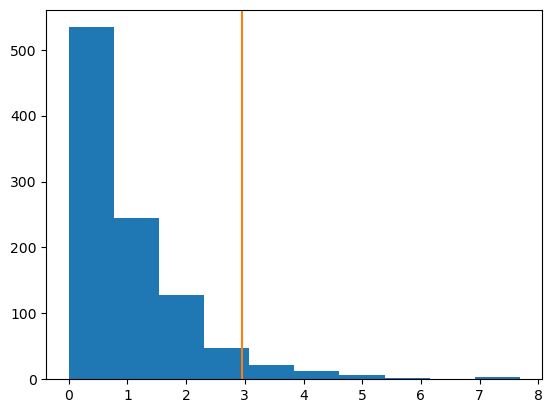

In [16]:
# Run your ANOVA model here.
anova_result_pt, anova_pval_pt = stats.f_oneway(df['weight6weeks'][df['Diet'] == 1], df['weight6weeks'][df['Diet'] == 2], df['weight6weeks'][df['Diet'] == 3])

print(f'ANOVA statistic: {anova_result_pt:.4f}, p = {anova_pval_pt:.4f}')

# Conduct your randomization test on weight6weeks

# Here is a function that will do this.
def my_f_distribution_pt(data, num_iterations, y_var):
    f_distn_pt = np.empty(num_iterations)
    for i in range(num_iterations):
        data['Diet'] = data['Diet'].sample(frac=1).values
        fstat_pt, pval_pt = stats.f_oneway(data[y_var][data['Diet'] == 1], 
                                     data[y_var][data['Diet'] == 2], 
                                     data[y_var][data['Diet'] == 3])
        f_distn_pt[i] = fstat_pt # save f-value to distribution
    return f_distn_pt

# Call the function

anova_distn_pt = my_f_distribution_pt(df.copy(), 1000, 'weight6weeks')

# Plot the results

print(f"The mean of the sampling distribution of F is: {np.mean(anova_distn_pt):.4f}.")
print(f"The standard deviation of the sampling distribution of F is: {np.std(anova_distn_pt):.4f}.")

plt.hist(anova_distn_pt)
plt.axvline(np.percentile(anova_distn_pt, 95), color='tab:orange')
plt.show()

#### Interpret your results.

YOUR RESPONSE HERE.

ANSWER: The one-way ANOVA statistic is F(2, 86)=0.8315, which is a smaller number, meaning the three group means are very similar. This is also supported by the p-value, which is 0.438, much larger than the threshold of p=0.05. This means there is not enough evidence to reject the null, thereby accepting the null hypothesis, showing that there are no group differences at the end of treatment. This result suggests that the three diets may not differ in results.


# 
#  
# 
# 
# Correlated Designs: Paired Samples T-Test

This part of the lab covers paired samples t-tests. We will use the dataset above to ask the question of whether people lost weight during their diets. Because we are working with paired samples t-tests, we will not concern ourselves with the question of WHICH diet people used. Instead, we will only think about whether they lost weight. 
 
##### We will ask whether diets are effective in promoting weight loss. We will complete the usual hypothesis testing steps.

- **H0:** There will be no change in participants' weights from pre- to post-diet (indicating that the diet was NOT effective).
- **H1:** There will be a decrease in participants' weights from pre- to post-diet (indicating that the diet was effective).
- **p-value:** .05
- **Test-statistic:** Paired samples t-test
- **Exclusions** We will exclude outliers that are +/-3 standard deviations from the mean.

In [20]:
# re-load the data to put the excluded participant back in.
df = pd.read_csv('Diet_R.csv')
print(df.head(),'\n')
print(f'There are {len(df)} participants in the dataset.')

   Person  gender  Age  Height  pre.weight  Diet  weight6weeks
0       1       0   22     159          58     1          54.2
1       2       0   46     192          60     1          54.0
2       3       0   55     170          64     1          63.3
3       4       0   33     171          64     1          61.1
4       5       0   50     170          65     1          62.2 

There are 90 participants in the dataset.


In [21]:
# Calculate the weight change and add this as a variable to the dataframe.

df['weight_change'] = df['weight6weeks'] - df ['pre.weight']
print(df.head(5), '\n')

   Person  gender  Age  Height  pre.weight  Diet  weight6weeks  weight_change
0       1       0   22     159          58     1          54.2           -3.8
1       2       0   46     192          60     1          54.0           -6.0
2       3       0   55     170          64     1          63.3           -0.7
3       4       0   33     171          64     1          61.1           -2.9
4       5       0   50     170          65     1          62.2           -2.8 



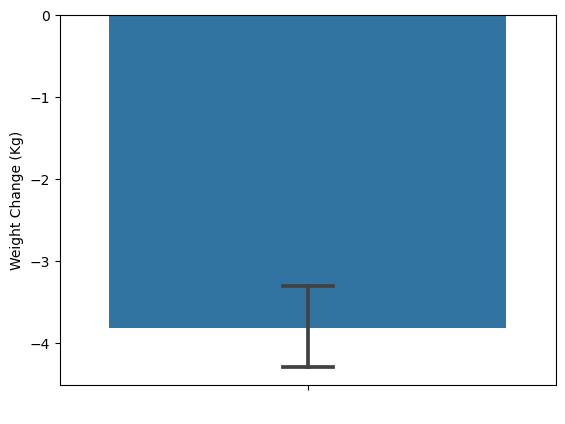

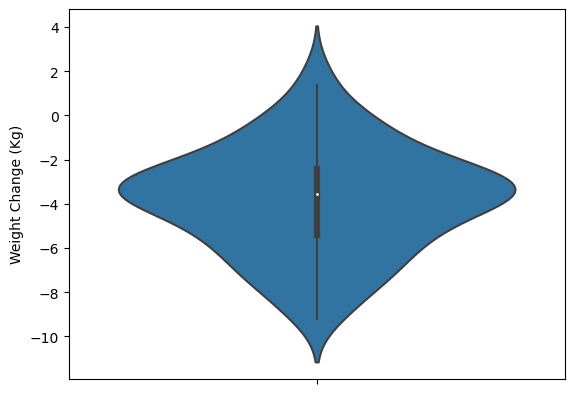

In [22]:
# Produce a bar plot of the results. To enhance your learning, pause the video and try to 
# do it yourself before you watch the solution.

sns.barplot(y='weight_change', data=df, estimator=np.mean, errorbar=('ci', 95), capsize=.1)
plt.ylabel('Weight Change (Kg)')
plt.xlabel(' ')
plt.show()

# Produce a violin plot also, to see what the distribution looks like. Try to do it yourself 
# before you watch the solution. 

sns.violinplot(data=df, y='weight_change')
plt.ylabel('Weight Change (Kg)')
plt.xlabel(' ')
plt.show()


## <font color="blue"> *Homework Problem 2a*</font>

#### What does this bar-plot show you about the data. Was the treatment effective at p<.05? How do you know?


This bar plot shows me that the data has a mean of about -4kg, meaning that on average, participants lost 4kg due to their assigned diet. I would assume that the treatments were effective at p<0.05, because losing 4kg in 6 weeks is a significant change that does not happen due to chance. For a treatment to be considered effective at p<0.05, it has to be very unlikely to happen due to chance, which I believe is accurate to the results of this study, meaning that there is unlikely to be chance involved.




## <font color="blue"> *Homework Problem 2b*</font>

#### What does the violin plot suggest about the distribution? Does anything look wrong to you? If so, how will you identify the issue(s)? Check this idea using what you learned in previous weeks.


The violin plot suggests this distribution has a lot of values around -3, and is normally distributed. This looks wrong, as diet group 2 is not normally distributed at the beginning of the study, meaning that the weight change distribution should not be completely normally distributed. It looks like the three different conditions have similar averages, but it is difficult to tell other than guessing based on the wideness of the middle of the plot. This is an issue, because it does not provide information on individual diets, which is what we are interested in. This can be identified by visualizing the data in the different diet groups, to identify differences between them. It looks like a very large set, from 4 to -11, and it makes me wonder if they are all in the same diet group or if they are in different groups.




## <font color="blue"> *Homework Problem 2c*</font>

#### Check this idea by:
 1) Producing a visualization of the data
 
 2) Running the Shapiro-Wilk test

 3) Checking if any outliers you see in the plot are +/-3 standard deviations from the mean

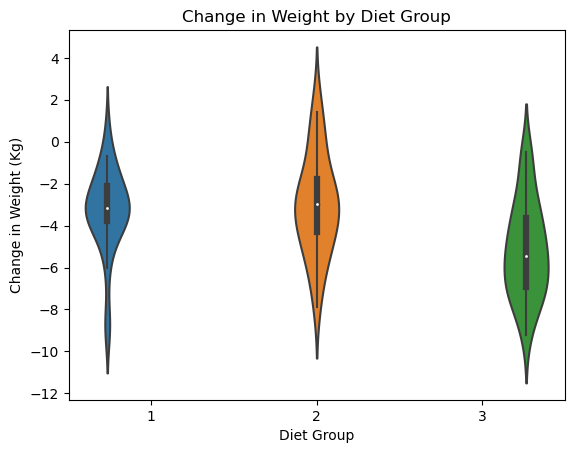

The Diet 1 weight changes are NOT normally distributed at the study end.
The Diet 2 weight changes are normally distributed at the study end.
The Diet 3 weight changes are normally distributed at the study end.
The grand mean of participants change in weight is: -3.8178 kg, sd = 2.4010.
The cut-off for low outliers is: -11.020667335276773
The cut-off for high outliers is: 3.385111779721217
The maximum ending weight in the dataset is: 2.1000000000000014 kg.
The minimum ending weight in the dataset is: -9.200000000000003 kg.



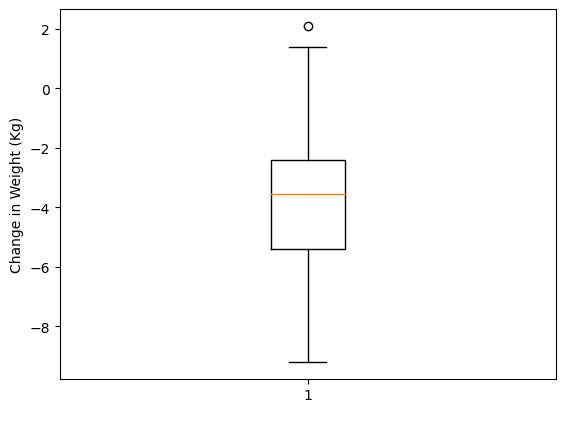

Outliers: []


In [89]:
# Visualization here (please make sure it is appropriately labeled).

sns.violinplot(data=df, x='Diet', y='weight_change', hue='Diet', palette='tab10', legend=False)
plt.legend().remove()
plt.ylabel('Change in Weight (Kg)')
plt.xlabel('Diet Group')
plt.title('Change in Weight by Diet Group')
plt.show()

#weight change is the difference between pre-weight and weight at 6 weeks, so a scatterplot displaying the relationship
#between the two data points is helpful as a visualization, to see outliers.


# Now run the Shapiro-Wilk Test and check the distribution. Be sure to print its output as well as the decision you 
# will make with respect to the hypothesis. Be careful of copy/paste errors.

for i in range(3):
    shapiro, p = stats.shapiro(df['weight_change'].loc[df['Diet']==i + 1])
    if p < .05:
        print(f'The Diet {i + 1} weight changes are NOT normally distributed at the study end.')
    else:
        print(f'The Diet {i + 1} weight changes are normally distributed at the study end.')

# Check for outliers, as you learned in previous labs

change_grand_mean = np.mean(df['weight_change'])
change_grand_sd = np.std(df['weight_change'], ddof=1)
print(f"The grand mean of participants change in weight is: {change_grand_mean:.4f} kg, sd = {change_grand_sd:.4f}.")
print(f"The cut-off for low outliers is: {change_grand_mean - (3 * change_grand_sd)}")
print(f"The cut-off for high outliers is: {change_grand_mean + (3 * change_grand_sd)}")
print(f"The maximum ending weight in the dataset is: {max(df['weight_change'])} kg.")
print(f"The minimum ending weight in the dataset is: {min(df['weight_change'])} kg.\n")

plt.boxplot(df['weight_change'])
plt.xlabel(' ')
plt.ylabel('Change in Weight (Kg)')
plt.show()

print(f'Outliers: {df["weight_change"].loc[df["weight_change"] > 3.385].values}')
#the point on the boxplot is not an outlier!

#### The change scores meet assumptions (no outliers, normal distribution, each participant is independent) so we will conduct the paired t-test using scipy's ttest_rel function.

In [18]:
# Calculate and print t statistic, the degrees of freedom, and the p-value

results = stats.ttest_rel(a=df['weight6weeks'], b=df['pre.weight'], alternative='less')

print(f'The observed t-value is: {results.statistic:.4f}')
print(f'The degrees of freedom for this t-value is: {results.df}')
print(f'The associated one-tailed p-value is: {results.pvalue}')

The observed t-value is: -15.0850
The degrees of freedom for this t-value is: 89
The associated one-tailed p-value is: 1.4876127825615118e-26


#### What if your dataset had contained outliers and you wanted to keep them, instead of removing them? Without removing existing outliers (if they were present), we would need to run a randomization test. We will do an exmaple of that now (even though we don't need to), so you can see how it would work. Start by thinking carefully about what that test should do. 

Remember that we want to keep the paired scores (a participant's pre.weight and their weight6weeks) together. To do that, we will use the weight_change vector we have been looking at above, instead of using the pre- and post-diet weights as we did in the paired samples t-test. If we do that, however, we only have 1 sample - so we will use the one-sample t-test on the comparison values to check this. 

We will start by calculating the one-sample t-test statistic and making sure that it is comparable with what we calculated above (it should be), but let's prove that to ourselves.

In [20]:
# Calculate and print the one-sample t statistic, the degrees of freedom, and the one-tailed p-value

results = stats.ttest_1samp(a=df['weight_change'], popmean=0, alternative='less')

print(f'The observed t-value is: {results.statistic:.4f}')
print(f'The degrees of freedom for this t-value is: {results.df}')
print(f'The associated one-tailed p-value is: {results.pvalue}')

The observed t-value is: -15.0850
The degrees of freedom for this t-value is: 89
The associated one-tailed p-value is: 1.4876127825615118e-26


#### Start with noting the steps you would need to do for your test. 

- define a function that takes some data and number of iterations as input and returns a t-distribution
 - create an array of 'num_iterations' in length to hold the statistics
 - define a vector ('signs') that consists of -1 & 1 that we can sample from
 - define a loop that runs for 'num_iterations' times
    - sample from 'signs' with replacement to get a vector of 1s & -1s where sample size = len(data)
    - multiply the change in weight with the signs vector
    - compute the t-test on the new vector 
    - record the t-test
 - return the distribution of t

In [21]:
# Here is a randomization function for this test.

def my_t_distn(data, num_iterations):
    distn_of_t = np.empty(num_iterations)
    signs = [1, -1]
    for i in range(num_iterations):
        sample_signs = np.random.choice(signs, size=len(data), replace=True)
        x = data * sample_signs
        tresult = stats.ttest_1samp(a=x, popmean=0)
        distn_of_t[i] = tresult.statistic
    return distn_of_t

The mean of the sampling distribution of t is: -0.0054.
The standard deviation of the sampling distribution of t is: 1.0078.


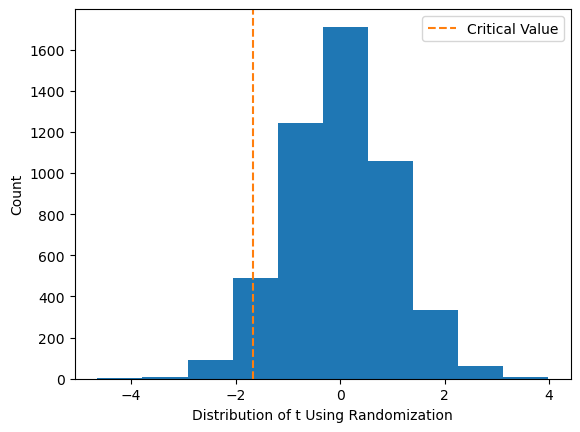

In [22]:
# Call the function, calculate its mean and sd, and plot its output. 
# If you did this correctly, the mean should be close to 0 and the sd close to 1. Note that you will not
# get exactly the same solution as the answer key because it will have computed a different set of randomized samples

d_of_t = my_t_distn(df['weight_change'].copy(), 5000)

print(f"The mean of the sampling distribution of t is: {np.mean(d_of_t):.4f}.")
print(f"The standard deviation of the sampling distribution of t is: {np.std(d_of_t):.4f}.")

plt.hist(d_of_t)
plt.axvline(np.percentile(d_of_t, 5), color='tab:orange', linestyle='dashed', label='Critical Value')
plt.ylabel('Count')
plt.xlabel('Distribution of t Using Randomization')
plt.legend()
plt.show()


#### p-value computation

Sometimes we want to know the exact p-value associated with a specific hypothesis test. To do that, we need to find the proportion of the distribution that is more extreme than the observed test value. Because we are using a 1-tailed test, we do that by counting the number of values in the empirically derived sampling distribution that are less than or equal to our observed statistic (remember that this is a 1-tailed test) and dividing by the number of values in that sampling distribution. In this example, that number is super small.

In [23]:
# p-value computation

empirical_pval = sum(d_of_t <= results.statistic) / len(d_of_t)
print(f'The empirical p-value (using randomization) associated with a t of {results.statistic:.4f} is: {empirical_pval:.10f}')

# Let's try out a few more values of t that are more like what we would find in real life.
# try a t-value of -3
print(f'The empirical p-value (using randomization) associated with a t of -3 is: {sum(d_of_t <= -3) / len(d_of_t)}')
# try a t-value of -2
empirical_pval = sum(d_of_t <= results.statistic) / len(d_of_t)
print(f'The empirical p-value (using randomization) associated with a t of -2 is: {sum(d_of_t <= -2) / len(d_of_t)}')
# try a t-value of -1
empirical_pval = sum(d_of_t <= results.statistic) / len(d_of_t)
print(f'The empirical p-value (using randomization) associated with a t of -1 is: {sum(d_of_t <= -1) / len(d_of_t)}')

The empirical p-value (using randomization) associated with a t of -15.0850 is: 0.0000000000
The empirical p-value (using randomization) associated with a t of -3 is: 0.0022
The empirical p-value (using randomization) associated with a t of -2 is: 0.0226
The empirical p-value (using randomization) associated with a t of -1 is: 0.1538


## Interpret the test results based on your original test. 

A paired samples t-test showed that participants in the dataset lost a statistically sigficant amount of weight over the course of their 6-week diet treatment, t(89) = -15.09, p < .001. This result shows that the diets were effective at promoting weight loss, as the average participant in the dataset lost 3.82kg (sd = 2.40kg). 


OPTIONAL EXERCISE: If you want to, and for practice, conduct a one-way ANOVA (like we did in HW5) to ask whether there are differences in the diets in terms of how much weight the people assigned to those conditions lost. Add additional code/markdown cells as needed.

# 
#  
# 
# 
# Correlated Designs: One-Way Repeated Measures ANOVA

Now, we will extend the idea of correlated samples to One-Way ANOVA. Here, we will ask how participants' scores change over different levels of an intervention. The participants, in this case, are students in an introductory statistics class (like this one). Over several years, the instructor noticed that smart students who studied hard sometimes struggled with taking exams. The data in this dataset ('exam_data.csv') come from students who took three exams during the course of the semester. This dataset is synthetic, but similar data aided in the development of the intervention reported here: https://news.stanford.edu/stories/2017/05/studying-strategically-equals-improved-exam-scores. In this course, the first exam of the term was indicated in the usual way - course outline, in class discussion, announcements from the course website. For the second exam, the instructor promoted the exam the usual way and did a review session and a video about how to study. For the third exam (the Final), the students went through a guided review of the course resources and wrote down how and when they would use each one over the course of their preparation. Did the exam scores differ? 

There are three variables in the dataset:
- Student: an id number associated with the student
- Exam: whether the exam was Midterm 1, Midterm 2, or the Final exam
- Score: the student's score on that exam, as a percentage of the total score

Start by stating your hypotheses and the initial elements of the hypothesis testing process.

- **H0:** There are no differences in the exam preparation strategies
- **H1:** The exam preparation strategies do differ
- **p-value:** .05
- **Test-statistic:** Because there are 3 exams taken by each of the students in the dataset, the data are correlated. We will therefore use a one-way, repeated measures ANOVA to conduct an omnibus test.
- **Exclusions** We will exclude outliers with scores +/- 3SDs from the mean.

In [31]:
# load the data and state how many cases there are in the dataset (read the description above carefully)
ex = pd.read_csv('exam_data.csv')
print(ex.head(),'\n')
print(f'There are {len(np.unique(ex["Student"]))} students in the dataset.')

   Student       Exam  Score
0        1  Midterm_1     64
1        2  Midterm_1     70
2        3  Midterm_1     82
3        4  Midterm_1     63
4        5  Midterm_1     51 

There are 197 students in the dataset.


#### Start by making a bar plot with the 95%CIs and violin plot to see what the distributions look like. In addition, compute the relevant descriptive statistics. 

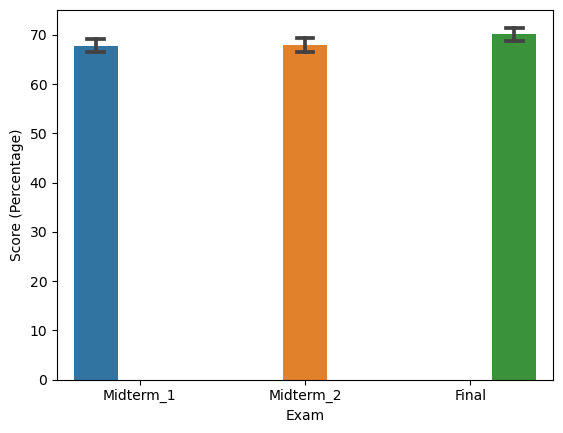

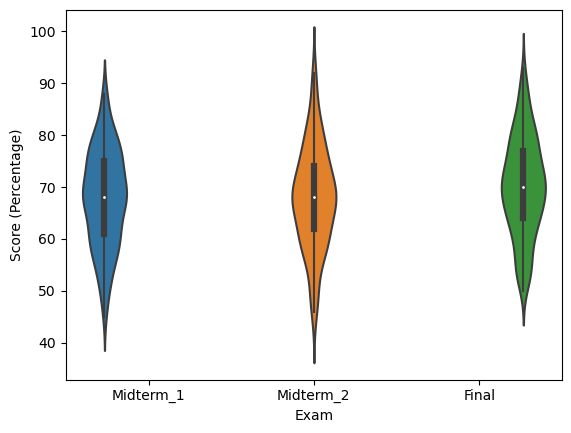

In [32]:
# Bar plot with 95%CIs

sns.barplot(x=ex['Exam'], y=ex['Score'], estimator=np.mean, errorbar=('ci', 95), hue=ex['Exam'], palette='tab10', capsize=0.1)
plt.legend().remove()
plt.ylabel('Score (Percentage)')
plt.xlabel('Exam')
plt.show()

# Violin plot

sns.violinplot(data=ex, x='Exam', y='Score', hue=ex['Exam'], palette='tab10')
plt.legend().remove()
plt.ylabel('Score (Percentage)')
plt.xlabel('Exam')
plt.show()

In [33]:
# Descriptive statistics
print(f"Mean: {ex['Score'].groupby(ex['Exam']).mean()}")
print(f"\nStandard Deviation: {ex['Score'].groupby(ex['Exam']).std()}")

Mean: Exam
Final        70.172589
Midterm_1    67.812183
Midterm_2    67.974619
Name: Score, dtype: float64

Standard Deviation: Exam
Final        9.462637
Midterm_1    9.315351
Midterm_2    9.853227
Name: Score, dtype: float64


#### What do you observe from the plots and descriptives?

The data are reasonably normally distributed (see descriptives and violin plots) and based on the violin plots, do not appear to contain any very far outliers. Based on both plots, it looks like scores improved for the Final. 

## <font color="blue"> *Homework Problem 4*</font>

Run the Shapiro-Wilk test and see if the result fits with your observation about the degree to which the samples are normally distributed. Be sure to print the test statistic and its p-value for each condition. Interpret the results in the markdown cell below.

In [45]:
# Now run the Shapiro-Wilk Test and check the normality of the distributions. Start with the midterm 1 scores.

for i in range(1):
    shapiro, p = stats.shapiro(ex['Score'].loc[ex['Exam'] =='Midterm_1'])
    if p < .05:
        print(f'The Midterm 1 scores are NOT normally distributed.')
    else:
        print(f'The Midterm 1 scores are normally distributed.')

# Next do the midterm 2 scores
for i in range(1):
    shapiro, p = stats.shapiro(ex['Score'].loc[ex['Exam'] =='Midterm_2'])
    if p < .05:
        print(f'The Midterm 2 scores are NOT normally distributed.')
    else:
        print(f'The Midterm 2 scores are normally distributed.')

# Finally, do the final exam scores
for i in range(1):
    shapiro, p = stats.shapiro(ex['Score'].loc[ex['Exam'] =='Final'])
    if p < .05:
        print(f'The Final Exam scores are NOT normally distributed.')
    else:
        print(f'The Final Exam scores are normally distributed.')


The Midterm 1 scores are normally distributed.
The Midterm 2 scores are normally distributed.
The Final Exam scores are normally distributed.


#### What do the Shapiro-Wilk tests show you?

YOUR RESPONSE HERE: The Shapiro-Wilk tests show me that each group is normally distributed and does not have significant departures from normality. It does this by testing the p-value of each group, and if the p-value is less than 0.05, then the group is normally distributed. In this case, each group is normally distributed to the extent that each has a p-value of less than 0.05.



#### Sphericity

Ordinarily we would formally test the assumption of sphericity using Mauchly's test. However, the package that includes this test is not distributed with Anconda, so it is likely that you don't have it (and understanding and writing the function itself is beyond the score of this class). We will therefore look at this assumption qualitatively, but not formally test it. 

To do that, we will look at the correlations between all the time conditions by generating scatter plots and correlation coefficients for each relationship.

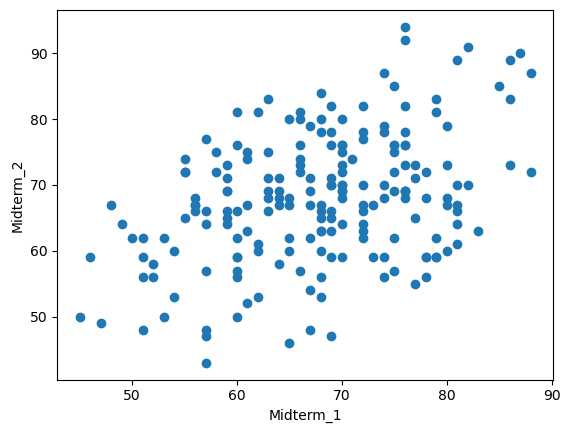

The correlation between Midterm 1 and Midterm 2 is: 0.4126


In [34]:
# Start with the correlation between the two midterms.
plt.scatter(x=ex['Score'].loc[ex['Exam']=='Midterm_1'], y=ex['Score'].loc[ex['Exam']=='Midterm_2'])
plt.xlabel('Midterm_1')
plt.ylabel('Midterm_2')
plt.show()

r=np.corrcoef(x=ex['Score'].loc[ex['Exam']=='Midterm_1'], y=ex['Score'].loc[ex['Exam']=='Midterm_2'])
print(f'The correlation between Midterm 1 and Midterm 2 is: {r[0,1]:.4f}')

## <font color="blue"> *Homework Problem 5*</font>

Produce and examine the remaining two correlations between the time points in the code cells below. Then make your observations about the degree to which the correlations look similar. 

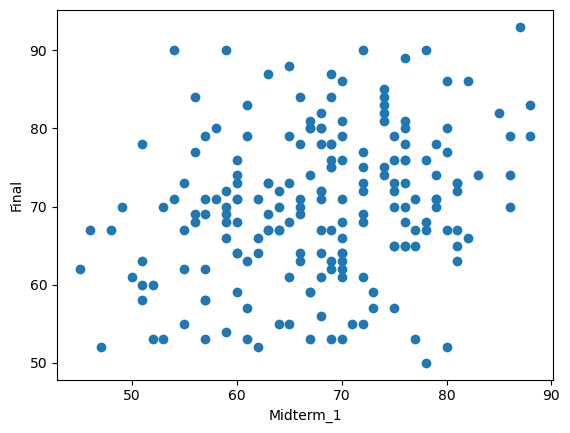

The correlation between Midterm 1 and the Final Exam is: 0.2658


In [46]:
# Now look at the correlation between Midterm 1 and the Final.

plt.scatter(x=ex['Score'].loc[ex['Exam']=='Midterm_1'], y=ex['Score'].loc[ex['Exam']=='Final'])
plt.xlabel('Midterm_1')
plt.ylabel('Final')
plt.show()

r=np.corrcoef(x=ex['Score'].loc[ex['Exam']=='Midterm_1'], y=ex['Score'].loc[ex['Exam']=='Final'])
print(f'The correlation between Midterm 1 and the Final Exam is: {r[0,1]:.4f}')

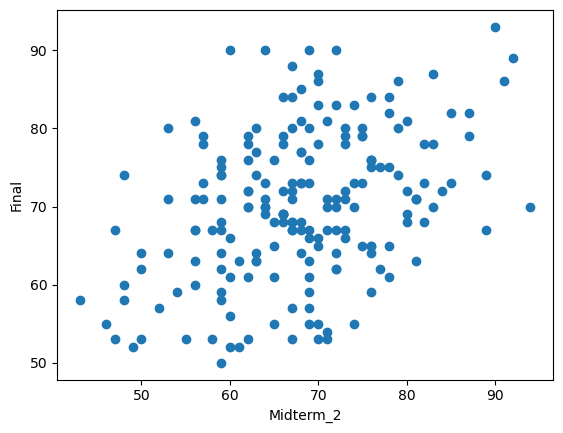

The correlation between Midterm 2 and the Final Exam is: 0.3837


In [47]:
# Now look at the correlation between Midterm 2 and the Final.

plt.scatter(x=ex['Score'].loc[ex['Exam']=='Midterm_2'], y=ex['Score'].loc[ex['Exam']=='Final'])
plt.xlabel('Midterm_2')
plt.ylabel('Final')
plt.show()

r=np.corrcoef(x=ex['Score'].loc[ex['Exam']=='Midterm_2'], y=ex['Score'].loc[ex['Exam']=='Final'])
print(f'The correlation between Midterm 2 and the Final Exam is: {r[0,1]:.4f}')

#### What are your observations from looking at the correlations?


YOUR RESPONSE HERE: From looking at the correlations, there appears to be a weak positive correlation for all of the permutations of exams. Midterm 1 and Midterm 2 have the strongest positive relationship, at 0.4126, meaning scores from Midterm 1 can be used to somewhat accurately predict Midterm 2, and vice versa. Midterm 1 and the Final Exam have the weakest correlation, which makes sense as there is the most amount of time between these two exams. Midterm 1 cannot be used as a strong predictor of the Final Exam score, with the correlation being 0.2658. Midterm 2 and the Final Exam are in the middle of these two, with a correlation of 0.3837. This means there is a correlation, but it is weak and cannot be used to accurately predict students' scores. Each scatterplot reflects the strength of each correlation, with the points of Midterm 1 and Midterm 2 appearing closer together and the points of Midterm 1 and the Final Exam appearing more spread out. Midterm 2 and the Final Exam are less scattered than the second correlation but more scattered than the first. The stronger the correlation, the more similar the exam preparation strategies are. 

## <font color="blue"> *Homework Problem 6a*</font>

#### Conduct a one-way repeated measures ANOVA

The link below contains a short tutorial on how to run RM ANOVA using a library called 'statsmodels'. Import just the relevant test in the code cell below (please run that cell before you try to make this work). 

For an exmaple of how to run it, see: https://www.geeksforgeeks.org/how-to-perform-a-repeated-measures-anova-in-python/

You already have the dataframe so you don't need to create or import it. Your job is to see if you can get the test to work.

In [48]:
# Import the relevant test
from statsmodels.stats.anova import AnovaRM

In [69]:
# RM-ANOVA

aov = AnovaRM(data=ex, depvar='Score', subject='Student', within=['Exam']).fit()
print(aov)

               Anova
     F Value Num DF  Den DF  Pr > F
-----------------------------------
Exam  5.8257 2.0000 392.0000 0.0032



## <font color="blue"> *Homework Problem 6b*</font>

Make your statistical decision and interpret your results in the markdown cell below. Be sure you explain your results in terms a person who had never taken a statistics course could undertsand.

YOUR RESPONSE HERE:

The F-statistic is equal to 5.8257, indicating a strong difference in the average exam scores, and the corresponding p-value is 0.003. As the p-value is less than 0.05, the null is rejected, meaning there is strong evidence to suggest exam preparation strategies have an influence on exam results. These results mean that exam scores are different enough that they are not due to individual differences in students, but can be related to exam preparation strategies. 

